In [1734]:
import pandas as pd
import matplotlib.pyplot as plt
from tdmsdata import TdmsData
import numpy as np
from scipy.optimize import curve_fit    
from scipy.odr import ODR, Model, RealData
from scipy.stats import gaussian_kde
import doppler_shift
import importlib
import os
import sys
from scipy.special import voigt_profile
import satlas as sat

This code processes the raw TDMS data, corrects for the Doppler shift, and makes the data fits 

In [1735]:
folder_path = '/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/Isotope shift'

In [1736]:
# Function to read TDMS file and extract raw data
def read_tdms(file, channel):
    TDMS = TdmsData(''.join(['/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/Isotope shift/{}'.format(file)]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array
    return raw_data

In [1737]:
# Function to create a dataset from raw data
def create_df(raw_data):
    return pd.DataFrame({'Cycle': raw_data[:, 0], 'Time(sec)': raw_data[:, 1], 'Wavelength (nm)': raw_data[:, 2]})

In [1738]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift)

    # Copying the original dataframe to avoid modifying it directly
    doppler_df = dataset.copy()
   
    # Get the original wavelengths from the dataframe 
    wavelengths = doppler_df['Wavelength (nm)']

    # Apply the Doppler shift to the wavelengths
    shifted_wls = doppler_shift.getshift(wavelengths, isotope)

    # Add the shifted wavelengths as a new column to the copied dataframe
    doppler_df['Wavelength (nm)'] = shifted_wls

    return doppler_df

In [1739]:
def process_tdms(raw_df, bins, isotope):
    # Extract wavelengths and compute counts
    wavelengths_raw = raw_df['Wavelength (nm)']
    counts_df = wavelengths_raw.value_counts().reset_index()
    counts_df.columns = ['Wavelength', 'Count']

    # Skip the first row which is injection + decay 
    counts_df = counts_df.iloc[1:].reset_index(drop=True)

    if isotope == 119:
        exclude_range = (counts_df['Wavelength'].min(), 1533.059)
        min_wavelength, max_wavelength = exclude_range
        counts_df = counts_df[~((counts_df['Wavelength'] >= min_wavelength) & (counts_df['Wavelength'] <= max_wavelength))]
  
    if isotope == 117:
        exclude_range = (counts_df['Wavelength'].min(), 1533.039)
        min_wavelength, max_wavelength = exclude_range
        counts_df = counts_df[~((counts_df['Wavelength'] >= min_wavelength) & (counts_df['Wavelength'] <= max_wavelength))]
            
    # Create bins and compute binned counts
    counts_df['Wavelength bin'] = pd.cut(counts_df['Wavelength'], bins)
    binned_counts_df = counts_df.groupby('Wavelength bin', observed=False)['Count'].sum().reset_index()

    # Compute bin midpoints
    binned_counts_df['Bin center'] = binned_counts_df['Wavelength bin'].apply(lambda x: x.mid)
    print(binned_counts_df)
 
    return counts_df, binned_counts_df 

In [1740]:
def get_peak_info(wavelengths, counts):
    if isinstance(wavelengths, pd.Index):
        wavelengths = pd.Series(wavelengths)
    
    max_count_index = counts.idxmax()
    max_wavelength = wavelengths.iloc[max_count_index]
    max_count = counts.iloc[max_count_index]

    # Calculate half maximum
    half_max_count = max_count / 2

    # Find wavelengths where count crosses the half maximum
    idx_below_half_max = counts >= half_max_count

    wavelengths_below_half_max = wavelengths[idx_below_half_max]

    left_bound = wavelengths_below_half_max.min()
    right_bound = wavelengths_below_half_max.max()

    fwhm = right_bound - left_bound

    return max_wavelength, fwhm

In [1741]:
def get_wavenumber(wavelength_nm):
    wavelength_cm = wavelength_nm * 1e-7
    wavenumber = 1 / wavelength_cm
    return wavenumber

In [1742]:
# This is for shifts: dnu = c*dlambda / lambda**2
def get_frequency(lambda_0, delta_lambda):
    c = 3.0 * 10**8
    center_freq = (c / lambda_0) * 1e-3 # THz  
    nu_start = c / (lambda_0 + (delta_lambda / 2))
    nu_stop = c / (lambda_0 - (delta_lambda / 2))
    delta_nu = nu_stop - nu_start # GHz 
    return center_freq, delta_nu

In [1743]:
def get_scatter_plot(wavelengths, counts, file):
    plt.scatter(wavelengths, counts)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Count')
    plt.title(f'{file[14:20]} raw data')
    # plt.xlim(1533.06,1533.10)
    plt.show()

    max_wl, fwhm = get_peak_info(wavelengths, counts)
    print(f'Peak WL: {max_wl} nm, FWHM: {fwhm}')


In [1744]:
def plot_kde(wavelengths, counts, bins, file):
    kde = gaussian_kde(wavelengths, weights=counts, bw_method=0.1)
    wavelength_range = np.linspace(wavelengths.min(), wavelengths.max(), 1000)
    kde_values = kde(wavelength_range)

    plt.plot(wavelength_range, kde_values)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Density')
    plt.title(f'{file[14:20]} Gaussian KDE, bins={bins}')
    plt.show()

    max_wl, fwhm = get_peak_info(pd.Series(wavelength_range), pd.Series(kde_values))
    print(f'Peak WL: {max_wl} nm, FWHM: {fwhm}')


In [1745]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [1746]:
def gaussian_exponential(x, A, mu, sigma, tau, bkg):
    # gaussian_part = gaussian(x, A, mu, sigma)
    # exponential = B * np.exp(x * -tau)

    # # transition = np.heaviside(x - transition_point, 0)
    # transition = 1 / (1 + np.exp(-(x - transition_point) / width)) # logistic function
    # # print(transition)
    # gaus = gaussian_part * (1 - transition)
    # exp = exponential * transition
    # test =  gaus+ exp
    # # print(gaus)
    # # print(exp)
    # exponential = B * np.exp(-(x - mu) / tau) + bkg
    
    # # Combine the two components using an error function
    # asymmetry = 0.5 * (1 - erfc((x - mu) / (np.sqrt(2) * sigma))) 
    
    # return gaussian(x, A, mu, sigma) * asymmetry + exponential * (1 - asymmetry) 
    exp_tail = A * np.exp(-(x - mu) / tau) * (x > mu)
    
    return gaussian(x,A,mu,sigma) + exp_tail * np.exp(-(mu - x)**2 / (2 * sigma**2)) + bkg


    # return test

In [1747]:
def voigt_fit(x, A, mu, sigma, gamma):
    return A * voigt_profile(x - mu, sigma, gamma)

In [1748]:
def asymmetric_fit(x, A, mu, sigma, gamma, tau, bkg, trans_width):
    voigt = A * voigt_profile(x - mu, sigma, gamma)
    exponential = A * np.exp(-(x - mu) / tau) * (x > mu)
    transition = 1 / (1 + np.exp(-(x - mu) / trans_width))
    
    return (1 - transition) * voigt + transition * exponential + bkg

    # return voigt + exponential * np.exp(-(mu - x)**2 / (2 * sigma**2)) + bkg

In [1749]:
def fitting(wavelengths, counts, bins, file):
    peak_wl, _ = get_peak_info(wavelengths, counts)
    peak_width = (max(wavelengths) - min(wavelengths)) / 20

    initial_guess_gaus = [np.max(counts), peak_wl, np.std(wavelengths)]
    # initial_guess_asym = [np.max(counts), peak_wl, np.std(wavelengths), peak_width, 100, min(counts), 0.1]
    initial_guess_voigt = [np.max(counts), peak_wl, np.std(wavelengths), peak_width]

    params_gaus, cov_gaus = curve_fit(gaussian, wavelengths, counts, p0=initial_guess_gaus)
    # params_asym, _ = curve_fit(asymmetric_fit, wavelengths, counts, p0=initial_guess_asym)
    params_voigt, conv_voigt = curve_fit(voigt_fit, wavelengths, counts, p0=initial_guess_voigt)

    x_fit = np.linspace(min(wavelengths), max(wavelengths), 1000)

    y_fit_gaus = gaussian(x_fit, *params_gaus)
    # y_fit_asym = asymmetric_fit(x_fit, *params_asym)
    y_fit_voigt = voigt_fit(x_fit, *params_voigt)

    y_errors = np.sqrt(counts)
    A_err, mu_err, sigma_err = np.sqrt(np.diag(cov_gaus))   

    peak_gaus = params_gaus[1]
    peak_voigt = params_voigt[1]

    # plt.errorbar(wavelengths, counts, yerr=y_errors, fmt='o',capsize=5, elinewidth=2, markersize=5)
    # plt.plot(x_fit, y_fit_gaus, color='red', label=f'Gaussian, {peak_gaus:.4f}')
    # plt.plot(x_fit, y_fit_voigt, color='blue', label=f'Voigt, {peak_voigt:.4f}')
    # # plt.plot(x_fit, y_fit_asym, color='blue', label='Gaussian + Exponential')
    # plt.xlabel('Wavelength (nm)')
    # plt.ylabel('Count')
    # plt.title(f'{file[14:]} fitting, bins={bins}')
    # # plt.xlim(1533.06,1533.10)
    # plt.legend()
    # plt.show()
    
    fwhm = (2 * np.sqrt(2 * np.log(2)) * params_gaus[2])

    # print(f'GAUSSIAN Peak {file[14:20]}: {params_gaus[1]}, FWHM: {2 * np.sqrt(2 * np.log(2)) * params_gaus[2]}')
    return peak_gaus, peak_voigt, fwhm, mu_err

In [1750]:
# Function to filter the data for Sn-122 because magnet was changed too early 
def filter_data_for_sn122(dataset):
    newcycle = dataset[dataset['Cycle'].between(0, 3)]
    wavelengths_122 = newcycle['Wavelength (nm)'].dropna().reset_index()
    return wavelengths_122

In [1751]:
# Doppler correction (nm)
def get_binned_data(file, isotope):
    raw_data = read_tdms(file, channel=1)
    raw_df = create_df(raw_data)
    if isotope == 122: 
        raw_df = filter_data_for_sn122(raw_df)

    doppler_df = doppler_shift_calc(raw_df, isotope)
    bins = 50
    counts_df, binned_counts_df = process_tdms(doppler_df, bins, isotope)

    wavelengths = counts_df['Wavelength']
    counts = counts_df['Count']
    bin_center = binned_counts_df['Bin center'].cat.categories.astype(float)
    binned_counts = binned_counts_df['Count']
    # get_scatter_plot(wavelengths, counts, file)
    # get_scatter_plot(bin_center, binned_counts, file)
    # plot_kde(bin_center, binned_counts, bins, file)
    # peak_wl_gaus, peak_wl_voigt, fwhm, gaus_fit_err = fitting(bin_center, binned_counts, bins, file)
    # return peak_wl_gaus, peak_wl_voigt, fwhm, gaus_fit_err
   
    return bin_center, binned_counts, bins, binned_counts_df


In [1752]:
# Wavenumber 
# wavenumber = get_wavenumber(wavelengths)
# bin_wavenumber = get_wavenumber(bin_center)
# peak_wn, fwhm_wn = get_peak_info(wavenumber, counts)
# peak_wn_bin, fwhm_wn_bin = get_peak_info(bin_wavenumber, binned_counts)
# print(f'RAW DATA Peak: {peak_wn} cm-1, FWHM: {fwhm_wn} cm-1')
# print(f'COR DATA Peak: {peak_wn_bin} cm-1, FWHM: {fwhm_wn_bin} cm-1')

In [1753]:
def get_sn_120_data():
        peak_wls_120_gaus, fwhms_120, gaus_fit_errs_120  = [], [], []
        peak_wls_120_freqs, fwhm_freqs, fit_err_freq, rel_freqs = [], [], [], []
      
        for filename in os.listdir(folder_path):
                if filename[14:20]=='Sn_120' and filename.endswith('.tdms'):
                        bin_center, binned_counts, bins, binned_counts_df = get_binned_data(filename, isotope=120)  
                        peak_wl_gaus, peak_wl_voigt, fwhm, gaus_fit_err = fitting(bin_center, binned_counts, bins, filename)

                        peak_wls_120_gaus.append(peak_wl_gaus)   
                        fwhms_120.append(fwhm) 
                        gaus_fit_errs_120.append(gaus_fit_err)
                        
                        center_freq_120, fwhm_freq = get_frequency(peak_wl_gaus, fwhm) # center freq THz, fwhm MHz, err MHz
                        center_freq_120, err_freq = get_frequency(peak_wl_gaus, gaus_fit_err) # center freq THz, fwhm MHz, err MHz
                        all_freq, _ = get_frequency(bin_center, 0)
                        rel_freq = np.array((center_freq_120 - all_freq) * 1e3) # GHz 

                        peak_wls_120_freqs.append(center_freq_120)
                        fwhm_freqs.append(fwhm)
                        fit_err_freq.append(err_freq*1e-3)
                        rel_freqs.append(rel_freq)

        rel_freqs = np.array(rel_freqs)         
        all_cycles_rel_freqs = np.mean(rel_freqs, axis=0)
        
        sn_120_data = {
        'isotope': 120,
        'peak by cycle': peak_wls_120_freqs, # THz 
        'peak by cycle nm': peak_wls_120_gaus,
        'err by cycle': gaus_fit_errs_120,
        'peak_wl_gaus': np.mean(peak_wls_120_gaus),
        'fwhm': np.mean(fwhms_120),
        'error': np.mean(gaus_fit_errs_120),
        'center_freq_120': np.mean(peak_wls_120_freqs),  # Average center frequency
        'fwhm freq': np.mean(fwhm_freqs),               # Average FWHM frequency
        'err freq': np.mean(fit_err_freq),               # Average error frequency (GHz)
        'rel freq': all_cycles_rel_freqs,
        'rel freq peak': 0,
        'binned counts': binned_counts,
        'bin centers': bin_center
    }

        return sn_120_data

In [1754]:
def ref_scans_plot():
    sn_120_data = get_sn_120_data()
    peak_wls_120_freqs = sn_120_data['peak by cycle']
    fit_err_freq = sn_120_data['err by cycle']

    x = np.arange(1,8)
    slope, intercept = np.polyfit(x, peak_wls_120_freqs, 1)
    y_fit = slope * x + intercept

    plt.errorbar(x, peak_wls_120_freqs, yerr=fit_err_freq, fmt='o')
    plt.plot(x, y_fit, color='red', label = f'm={slope*1e6:.2f} MHz')#, b={intercept:.4f}')
    plt.ylabel('Absoulte frequency (THz)')
    plt.legend()
    plt.show()

In [1755]:
def process_even_isotopes():
    sn_120_data = get_sn_120_data()
    center_freq_120 = sn_120_data['center_freq_120']

    isotopes = {
        'Sn_116': 116,
        'Sn_118': 118,
        'Sn_122': 122,
        'Sn_124': 124
    }
    
    # Initialize the data dictionary
    even_isotope_data = {}
    
    for isotope_name, isotope_number in isotopes.items():
        for filename in os.listdir(folder_path):
            if isotope_name in filename and filename.endswith('.tdms'):
                bin_center, binned_counts, bins, binned_counts_df = get_binned_data(filename, isotope=isotope_number)
                peak_wl_gaus, peak_wl_voigt, fwhm, err = fitting(bin_center, binned_counts, bins, filename)
                shift = peak_wl_gaus - sn_120_data['peak_wl_gaus']
                center_freq, fwhm_freq = get_frequency(peak_wl_gaus, fwhm)
                center_freq, err_freq = get_frequency(peak_wl_gaus, err)
                center_freq, shift_freq = get_frequency(peak_wl_gaus, shift) # shift in GHz 
                all_freq, _ = get_frequency(bin_center, 0)
                rel_freq = (center_freq_120 - all_freq) * 1e3 # GHz
           
                # Store data in the dictionary
                even_isotope_data[isotope_name] = {
                    'isotope': isotope_number,
                    'peak_wl_gaus': peak_wl_gaus,
                    'peak_wl_voigt': peak_wl_voigt,
                    'fwhm': fwhm,
                    'error': err,
                    'shift': shift, 
                    'rel freq peak': shift_freq, 
                    'fwhm freq': fwhm_freq,
                    'err freq': err_freq,
                    'rel freq': rel_freq,
                    'binned counts': binned_counts
                }

    return even_isotope_data

In [1765]:
def process_odd_isotopes():
    sn_120_data = get_sn_120_data()
    center_freq_120 = sn_120_data['center_freq_120']

    isotopes = {
        'Sn_117': 117,
        'Sn_119': 119
    }

    odd_isotope_data = {}

    for isotope_name, isotope_number in isotopes.items():
        for filename in os.listdir(folder_path):
            if isotope_name in filename and filename.endswith('.tdms'):
                bin_center, binned_counts, bins, binned_counts_df = get_binned_data(filename, isotope=isotope_number)
                all_freq, _ = get_frequency(bin_center, 0)
                rel_freq = (center_freq_120 - all_freq) * 1e3 # GHz 
                weighted_center = np.sum(bin_center * binned_counts) / np.sum(binned_counts)
                new_bins = bin_center - weighted_center
                center_freq, shift_freq = get_frequency(weighted_center, new_bins) # GHz 

            # shift_120 = sn_120_data['bin centers'] - sn_120_data['peak_wl_gaus']
            # center_freq_120, shift_freq_120 = get_frequency(sn_120_data['bin centers'], shift_120) # shift in GHz 

                odd_isotope_data[isotope_name] = {
                    'isotope': isotope_number,
                    'rel freq': rel_freq,
                    'binned counts': binned_counts,
                    'weighted center': weighted_center,
                    'center freq': center_freq,
                    'rel freq bins': shift_freq
                }
   
    return odd_isotope_data

          Wavelength bin  Count Bin center
0   (1533.046, 1533.048]     15  1533.0470
1    (1533.048, 1533.05]      1  1533.0490
2    (1533.05, 1533.052]      5  1533.0510
3   (1533.052, 1533.055]      8  1533.0535
4   (1533.055, 1533.057]     15  1533.0560
5   (1533.057, 1533.059]     42  1533.0580
6   (1533.059, 1533.061]     33  1533.0600
7   (1533.061, 1533.063]     47  1533.0620
8   (1533.063, 1533.066]     31  1533.0645
9   (1533.066, 1533.068]     32  1533.0670
10   (1533.068, 1533.07]     52  1533.0690
11   (1533.07, 1533.072]     19  1533.0710
12  (1533.072, 1533.074]     42  1533.0730
13  (1533.074, 1533.077]     34  1533.0755
14  (1533.077, 1533.079]     56  1533.0780
15  (1533.079, 1533.081]     28  1533.0800
16  (1533.081, 1533.083]     34  1533.0820
17  (1533.083, 1533.085]     38  1533.0840
18  (1533.085, 1533.088]     33  1533.0865
19   (1533.088, 1533.09]     66  1533.0890
20   (1533.09, 1533.092]    186  1533.0910
21  (1533.092, 1533.094]   2533  1533.0930
22  (1533.0

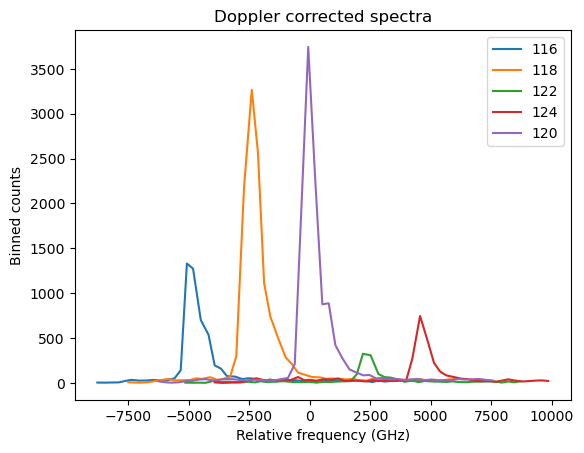

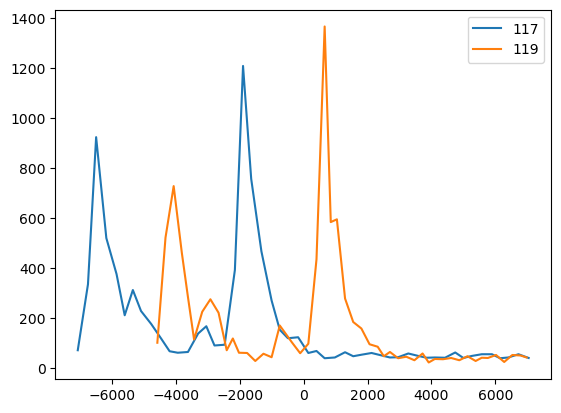

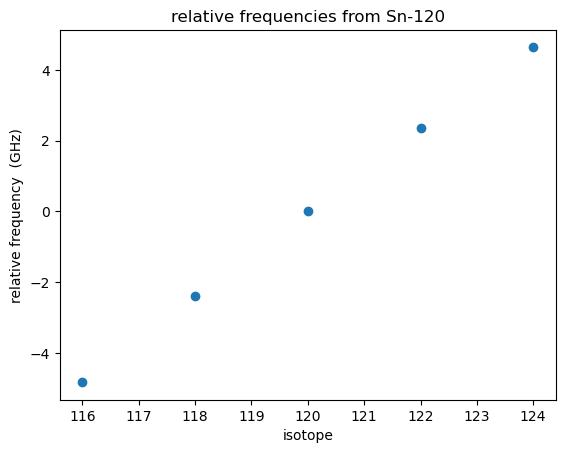

In [1757]:
def plot_iso_offset():
    even_isotope_data = process_even_isotopes()
    odd_isotope_data = process_odd_isotopes()
    sn_120_data = get_sn_120_data()
    all_isotopes = {**even_isotope_data, **odd_isotope_data, 'Sn_120': sn_120_data} # Sn 120 is a special case because it only has one key 

    isotopes = []
    wavelengths = []
    errs = []
    freqs = []
    errs_freqs = []
    # rel_freqs = []
    
    for data in all_isotopes.values():
        if data['isotope'] % 2 == 0:
            isotopes.append(data['isotope'])
            wavelengths.append(data['peak_wl_gaus'])
            errs.append(data['error'])
            freqs.append(data['rel freq peak'])
            errs_freqs.append(data['err freq'])
            plt.plot(data['rel freq']*1e3, data['binned counts'], label=data['isotope']) # 50 bins in WL = 0.002 nm bin width = 560 MHz 
     
    plt.xlabel('Relative frequency (GHz)')
    plt.ylabel('Binned counts')
    plt.title('Doppler corrected spectra')
    plt.legend()
    plt.show()

    for data in all_isotopes.values():
        if data['isotope'] % 2 == 1:
            plt.plot(data['rel freq']*1e3, data['binned counts'], label=data['isotope']) # 50 bins in WL = 0.002 nm bin width = 560 MHz 
    plt.legend()
    plt.show()
    
    # sn_120_x = [119.4, 119.6, 119.8, 120, 120.2, 120.4, 120.6]
    # peaks120 = sn_120_data['peak by cycle nm']
    
    # Plot Gaussian peak wavelengths with error bars
    # plt.errorbar(isotopes, wavelengths, yerr=errs, fmt='o')
    # # plt.scatter(sn_120_x, peaks120)
    # plt.xlabel('isotope')
    # plt.ylabel('peak (nm)')
    # plt.title('Doppler corrected peak wavelengths')
    # plt.show()

    plt.errorbar(isotopes, freqs, yerr=errs_freqs, fmt='o')
    plt.xlabel('isotope')
    plt.ylabel('relative frequency  (GHz)')
    plt.title('relative frequencies from Sn-120')
    plt.show()

plot_iso_offset()

In [1758]:
def king_plot():
    even_isotope_data = process_even_isotopes()
    shifts_freq_mine = []
    mine_err = []

    for data in even_isotope_data.values():
        shifts_freq_mine.append(data['rel freq peak'])
        mine_err.append(data['err freq'])

    A = np.array([116,118,122,124])
    A_prime = 120
    new_mass_cors = []

    for i in range(len(A)):
        new_mass_cor = (A_prime*A[i])/(A_prime-A[i]) 
        new_mass_cors.append(new_mass_cor)

    shifts_freq_lit = np.array([-576.04, -270.24, 235.35, 441.15]) / 1e3 # GHz from data sheet 
    lit_err = np.array([0.15, 0.15, 0.15, 0.15]) / 1e3 * np.abs(new_mass_cors) # GHz 

    # other_data = np.array([200.861, 185.871, 140.903, 131.909, 44.969, 44.969]) #IS MHz from Hindmarsh & Kuhn 

    # shifts_freq_mine = np.array([shift_freq_116, shift_freq_118, shift_freq_122, shift_freq_124]) # GHz 
    # mine_err = (np.array([shift_freq_err_116, shift_freq_err_118, shift_freq_err_122, shift_freq_err_124])) * np.abs(new_mass_cors) # GHz 
    mine_err = mine_err * np.abs(new_mass_cors)

    x = np.array(shifts_freq_mine) * new_mass_cors
    y = np.array(shifts_freq_lit) * new_mass_cors


    def linear_func(B, x):
        return B[0] * x + B[1]

    # Create a model for ODR
    linear_model = Model(linear_func)

    # Create a RealData object
    data = RealData(x, y, sx=mine_err, sy=lit_err)

    # Create ODR object
    odr_obj = ODR(data, linear_model, beta0=[-1., -14000])

    # Run the regression
    out = odr_obj.run()

    # Extract the parameters
    m, b = out.beta
    m_err, b_err = out.sd_beta

    print(out.beta)
    print(out.sd_beta)

    # Calculate x and y intercepts
    x_intercept = -b / m
    y_intercept = b

    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = m * x_fit + b

    for i in range(len(x)):
        # plt.scatter(x[i], y[i])
        plt.errorbar(x[i], y[i], xerr=lit_err[i], yerr=mine_err[i], fmt='o')
        plt.text(x[i], y[i], f'({A[i]}-{A_prime})', fontsize=10, ha='center')
    # plt.plot(x, y_fit, color='red', ls = ':')
    # plt.plot(x_fit, y_fit)
    # plt.text(-17100, -1500, s =f'b={popt[0]:.2f}, {popt[1]:.2f} GHz')
    plt.text(-17200, -1500, s=f'{m:.2f}({m_err:.2f}), {b:.2f}({b_err:.2f})')
    plt.plot(x_fit, y_fit)
    plt.ylabel('286.3nm GHz amu') 
    plt.xlabel('1533nm GHz amu')  
    # plt.legend() 
    # plt.gca().invert_xaxis()
    # plt.gca().invert_yaxis()

    plt.show()


In [1759]:
# sn_120_data = get_sn_120_data()
# for filename in os.listdir(folder_path):
#     if filename[14:20]=='Sn_117' and filename.endswith('.tdms'):
#         bin_center, binned_counts, bins = get_binned_data(filename, isotope=117)  
#         shift = bin_center - sn_120_data['peak_wl_gaus']
#         # center_freq, shift_freq = get_frequency(bin_center, shift) # shift in GHz 
#         shift_120 = sn_120_data['bin centers'] - sn_120_data['peak_wl_gaus']
#         center_freq_120, shift_freq_120 = get_frequency(sn_120_data['bin centers'], shift_120) # shift in GHz 

# # plt.plot(bin_center, binned_counts)
# # plt.plot(shift_freq, binned_counts)
# # plt.plot(shift_freq_120, sn_120_data['binned counts'])
# # plt.show()

# # plt.plot(bin_center, binned_counts/np.max(binned_counts))

# weighted_center = np.sum(bin_center * binned_counts) / np.sum(binned_counts)
# print(weighted_center)

# new_bins = bin_center - weighted_center

# center_freq, shift_freq = get_frequency(weighted_center, new_bins) # GHz 

# plt.plot(shift_freq, binned_counts) # GHz 



          Wavelength bin  Count Bin center
0   (1533.046, 1533.048]     15  1533.0470
1    (1533.048, 1533.05]      1  1533.0490
2    (1533.05, 1533.052]      5  1533.0510
3   (1533.052, 1533.055]      8  1533.0535
4   (1533.055, 1533.057]     15  1533.0560
5   (1533.057, 1533.059]     42  1533.0580
6   (1533.059, 1533.061]     33  1533.0600
7   (1533.061, 1533.063]     47  1533.0620
8   (1533.063, 1533.066]     31  1533.0645
9   (1533.066, 1533.068]     32  1533.0670
10   (1533.068, 1533.07]     52  1533.0690
11   (1533.07, 1533.072]     19  1533.0710
12  (1533.072, 1533.074]     42  1533.0730
13  (1533.074, 1533.077]     34  1533.0755
14  (1533.077, 1533.079]     56  1533.0780
15  (1533.079, 1533.081]     28  1533.0800
16  (1533.081, 1533.083]     34  1533.0820
17  (1533.083, 1533.085]     38  1533.0840
18  (1533.085, 1533.088]     33  1533.0865
19   (1533.088, 1533.09]     66  1533.0890
20   (1533.09, 1533.092]    186  1533.0910
21  (1533.092, 1533.094]   2533  1533.0930
22  (1533.0

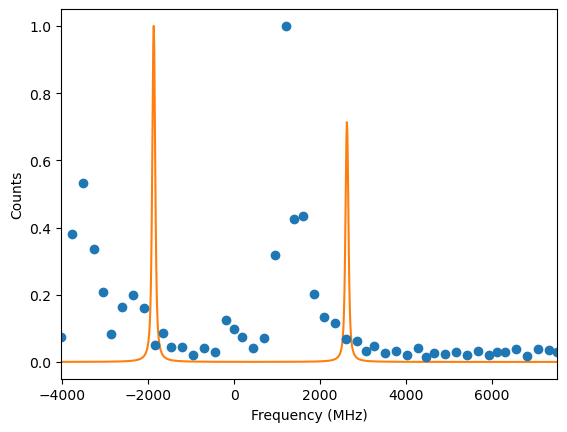

In [1771]:
def HFS_fitting():
    odd_isotope_data = process_odd_isotopes()
    for data in odd_isotope_data.values():
        shift_freq = data['rel freq bins']
        binned_counts = data['binned counts']
   
           
    # Parameter and model initialization
    I = 0.5 # spin
    J = [1.5, 2.5] # electronic total angular moment L +- S 
    ABC = [0, -1500.0, 0, 0, 0, 0] # A = mag diploe, B = ele quadrupole does not contribute 
    centroid = 0
    shape = ''
    fwhm = 1000
    background = [0]
    scale = 1.0


    # Initialize the model
    model = sat.HFSModel(I, J, ABC, centroid, fwhm=fwhm, shape=shape, scale=scale, background_params=background)
    # basemodel_low = sat.HFSModel(I, J, ABC, centroid, fwhm=fwhm, scale=scale, background_params=background)


    # Set boundaries
    # boundaries = {'Scale': {'min': -4000, 'max': 4000}} # MHz 
    # model.set_boundaries(boundaries)

    # 
    x = shift_freq * 1e3 # MHz 
    y = binned_counts / np.max(binned_counts)

    # Chi-square analysis
    # sat.chisquare_spectroscopic_fit(model, x, y)
    # model.display_chisquare_fit()
    model.plot(x,y)




HFS_fitting()
